## Imports

In [190]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import tqdm

from ephys_atlas.plots import figure_features_chspace, plot_probe_rect, plot_probe_rect2
from ephys_atlas.encoding import voltage_features_set
from ephys_atlas.data import load_voltage_features, prepare_df_voltage

In [ ]:
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'DejaVu Sans',
    #'axes.labelweight': 'bold',
    'axes.titlesize': 14,
    #'axes.titleweight': 'bold',
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 12
})

## Constants

In [137]:
QUANTILES = [0.01, 0.1, 0.9, 0.99]
BINS = 50

## Data loading

In [3]:
local_data_path = Path('/home/cyrille/GIT/IBL/paper-ephys-atlas/data')

features = voltage_features_set()
mapping = 'Allen'
label = 'latest'

In [4]:
df_voltage, df_clusters, df_channels, df_probes = \
    load_voltage_features(local_data_path.joinpath(label), mapping=mapping)

2025-02-18 15:44:33 INFO     data.py:399  Loaded 391314 channels
2025-02-18 15:44:33 INFO     data.py:401  Remains 384418 channels after NaNs filtering


In [76]:
df_voltage = prepare_df_voltage(df_voltage, df_channels)

## Regions

In [187]:
from iblatlas.atlas import BrainRegions
br = BrainRegions()

In [188]:
beryl_ids = df_voltage.beryl_id.unique()
acronyms = br.id2acronym(beryl_ids)
idx = np.argsort(acronyms)
acronyms = acronyms[idx]
beryl_ids = beryl_ids[idx]

## Features

In [5]:
pids = df_voltage.index.get_level_values(0).unique()

In [82]:
df_voltage

alpha_mean   alpha_std  \
pid                                  channel                           
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4 0        197.210450  190.478658   
                                     1        194.839222  186.516420   
                                     2        138.978804  195.718681   
                                     3        169.178477  110.850311   
                                     4        122.773706   80.443544   
...                                                  ...         ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379      115.299620   74.028424   
                                     380      142.860548   94.239179   
                                     381      147.808486  133.909545   
                                     382      196.486313  194.143250   
                                     383      171.983269  147.854649   

                                              spike_count  peak_time_secs  \
pid                                  channel                                
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4 0                786        0.000025   
                                     1               1219        0.000024   
                                     2               1413        0.000027   
                                     3                399        0.000026   
                                     4                612        0.000022   
...                                                   ...             ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379              361        0.000006   
                                     380              513        0.000006   
                                     381             1029        0.000004   
                                     382              578        0.000005   
                                     383              501        0.000010   

                                              peak_val  trough_time_secs  \
pid                                  channel                               
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4 0       -3.364660          0.000339   
                                     1       -3.251131          0.000342   
                                     2       -3.822328          0.000341   
                                     3       -2.894536          0.000360   
                                     4       -2.923776          0.000340   
...                                                ...               ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379     -0.758633          0.000362   
                                     380     -1.222476          0.000360   
                                     381     -0.817315          0.000359   
                                     382     -1.281809          0.000351   
                                     383     -1.107193          0.000354   

                                              trough_val  tip_time_secs  \
pid                                  channel                              
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4 0          1.418666      -0.000378   
                                     1          1.362056      -0.000367   
                                     2          1.580183      -0.000375   
                                     3          1.176652      -0.000378   
                                     4          1.230062      -0.000365   
...                                                  ...            ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379        0.270088      -0.000432   
                                     380        0.445692      -0.000432   
                                     381        0.279528      -0.000433   
                                     382        0.445679      -0.000405   
                                     383        0.445684      -0.000433   

                                               tip_val  recovery_time_secs  \
pid                                  channel                    

In [83]:
df_voltage.shape

(326802, 62)

In [117]:
df_voltage.acronym

pid                                   channel
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4  0          TRN
                                      1          TRN
                                      2          TRN
                                      3          TRN
                                      4          TRN
                                                ... 
ffb1b072-2de7-44a4-8115-5799b9866382  379        PRM
                                      380        PRM
                                      381        PRM
                                      382        PRM
                                      383        PRM
Name: acronym, Length: 326802, dtype: object

In [85]:
df_voltage.index.names

FrozenList(['pid', 'channel'])

In [86]:
df_voltage.index.shape

(326802,)

## Distribution plotting functions

In [159]:
def select_series(df, feature, acronym=None, beryl_id=None):
    if acronym is not None:
        series = df.loc[df['acronym'] == acronym, feature]
    elif beryl_id is not None:
        series = df.loc[df['beryl_id'] == beryl_id, feature]
    else:
        series = df[feature]
    return series

In [155]:
def plot_histogram(series, ax=None, quantiles=None, bins=None, xlabel=None, title=None):
    quantiles = quantiles if quantiles is not None else QUANTILES
    quantile_values = np.quantile(series, quantiles)

    bins = bins if bins is not None else BINS

    hist_values, bin_edges = np.histogram(series, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    color_indices = np.digitize(bin_centers, quantile_values, right=True)
    colors = cm.viridis(color_indices / color_indices.max())

    ax.bar(bin_edges[:-1], hist_values, width=np.diff(bin_edges), color=colors, align='edge')

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.text(
        0.95, 0.95, f"{len(series):,} samples", 
        transform=ax.transAxes, ha='right', va='top', fontsize=12,
    )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='both', direction='out', length=6)
    ax.set_facecolor('#f9f9f9')
    plt.tight_layout()

## Plots

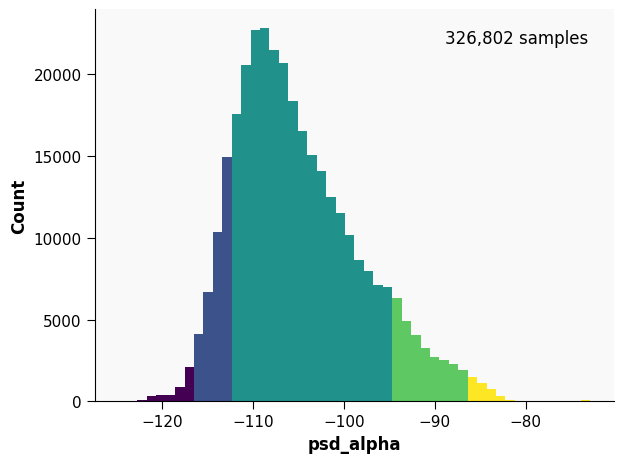

In [166]:
fig, ax = plt.subplots()
series = select_series(df_voltage, feature)
plot_histogram(series, ax=ax, xlabel=feature, title=None)
plt.show()

In [169]:
feature = 'psd_alpha'

In [193]:
grid_size = (5, 3)
subplots_per_page = grid_size[0] * grid_size[1]

chunks = [
    (beryl_ids[i:i + subplots_per_page], acronyms[i:i + subplots_per_page])
    for i in range(0, len(beryl_ids), subplots_per_page)
]

for feature in features:
    pdf_filename = f"histograms_{feature}.pdf"
    print("Generating", pdf_filename, "...")
    with PdfPages(pdf_filename) as pdf:
        for beryl_chunk, acronym_chunk in tqdm.tqdm(chunks):
            fig, axes = plt.subplots(*grid_size, figsize=(8.27*1.5, 11.69*1.5), dpi=200)
            axes = axes.flatten()
    
            for i, (beryl_id, acronym) in enumerate(zip(beryl_chunk, acronym_chunk)):
                ax = axes[i]
                series = select_series(df_voltage, feature, beryl_id=beryl_id)
                plot_histogram(series, ax=ax, xlabel=feature, title=acronym)
    
            # Hide unused subplots
            for i in range(len(beryl_chunk), len(axes)):
                fig.delaxes(axes[i])
    
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)

Generating histograms_rms_ap.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:20<00:00,  4.03s/it]


Generating histograms_rms_lf.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.86s/it]


Generating histograms_psd_delta.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:16<00:00,  3.82s/it]


Generating histograms_psd_theta.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:16<00:00,  3.84s/it]


Generating histograms_psd_alpha.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.86s/it]


Generating histograms_psd_beta.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.88s/it]


Generating histograms_psd_gamma.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.96s/it]


Generating histograms_alpha_mean.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:13<00:00,  3.68s/it]


Generating histograms_alpha_std.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.95s/it]


Generating histograms_spike_count.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:14<00:00,  3.74s/it]


Generating histograms_peak_time_secs.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:15<00:00,  3.75s/it]


Generating histograms_peak_val.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:20<00:00,  4.04s/it]


Generating histograms_trough_time_secs.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:14<00:00,  3.74s/it]


Generating histograms_trough_val.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:22<00:00,  4.11s/it]


Generating histograms_tip_time_secs.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:14<00:00,  3.70s/it]


Generating histograms_tip_val.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:15<00:00,  3.76s/it]


Generating histograms_polarity.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:14<00:00,  3.74s/it]


Generating histograms_depolarisation_slope.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:23<00:00,  4.19s/it]


Generating histograms_repolarisation_slope.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.64s/it]


Generating histograms_recovery_time_secs.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:15<00:00,  3.77s/it]


Generating histograms_recovery_slope.pdf ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:14<00:00,  3.74s/it]


In [196]:
len(features), features

(21,
 ['rms_ap',
  'rms_lf',
  'psd_delta',
  'psd_theta',
  'psd_alpha',
  'psd_beta',
  'psd_gamma',
  'alpha_mean',
  'alpha_std',
  'spike_count',
  'peak_time_secs',
  'peak_val',
  'trough_time_secs',
  'trough_val',
  'tip_time_secs',
  'tip_val',
  'polarity',
  'depolarisation_slope',
  'repolarisation_slope',
  'recovery_time_secs',
  'recovery_slope'])

In [205]:
grid_size = (5, 3)
subplots_per_page = grid_size[0] * grid_size[1]

chunks = [
    features[i:i + subplots_per_page]
    for i in range(0, len(features), subplots_per_page)
]

for beryl_id, acronym in zip(beryl_ids, acronyms):
    pdf_filename = f"per_region/histograms_{acronym}.pdf"
    print("Generating", pdf_filename, "...")
    with PdfPages(pdf_filename) as pdf:
        for feature_chunk in tqdm.tqdm(chunks):
            fig, axes = plt.subplots(*grid_size, figsize=(8.27*1.5, 11.69*1.5), dpi=200)
            axes = axes.flatten()
    
            for i, feature in enumerate(feature_chunk):
                ax = axes[i]
                series = select_series(df_voltage, feature, beryl_id=beryl_id)
                plot_histogram(series, ax=ax, xlabel=feature, title=acronym)
    
            # Hide unused subplots
            for i in range(len(feature_chunk), len(axes)):
                fig.delaxes(axes[i])
    
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)

Generating per_region/histograms_AAA.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]


Generating per_region/histograms_ACAd.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Generating per_region/histograms_ACAv.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.78s/it]


Generating per_region/histograms_ACB.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.27s/it]


Generating per_region/histograms_AD.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]


Generating per_region/histograms_ADP.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.72s/it]


Generating per_region/histograms_AHN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


Generating per_region/histograms_AId.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]


Generating per_region/histograms_AIp.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.29s/it]


Generating per_region/histograms_AIv.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


Generating per_region/histograms_AM.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]


Generating per_region/histograms_AMB.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_ANcr1.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_ANcr2.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.53s/it]


Generating per_region/histograms_AOB.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]


Generating per_region/histograms_AON.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.71s/it]


Generating per_region/histograms_AP.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_APN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.71s/it]


Generating per_region/histograms_APr.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]


Generating per_region/histograms_AT.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_AUDd.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.58s/it]


Generating per_region/histograms_AUDp.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


Generating per_region/histograms_AUDpo.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]


Generating per_region/histograms_AUDv.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_AV.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.61s/it]


Generating per_region/histograms_AVP.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


Generating per_region/histograms_Acs5.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.62s/it]


Generating per_region/histograms_BLA.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.61s/it]


Generating per_region/histograms_BMA.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.78s/it]


Generating per_region/histograms_BST.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_CA1.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_CA2.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]


Generating per_region/histograms_CA3.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]


Generating per_region/histograms_CEA.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.75s/it]


Generating per_region/histograms_CENT2.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.82s/it]


Generating per_region/histograms_CENT3.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]


Generating per_region/histograms_CL.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]


Generating per_region/histograms_CLA.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.16s/it]


Generating per_region/histograms_CLI.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.72s/it]


Generating per_region/histograms_CM.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.81s/it]


Generating per_region/histograms_COAa.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.75s/it]


Generating per_region/histograms_COAp.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]


Generating per_region/histograms_COPY.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_CP.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_CS.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.72s/it]


Generating per_region/histograms_CU.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.75s/it]


Generating per_region/histograms_CUL4 5.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]


Generating per_region/histograms_CUN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.72s/it]


Generating per_region/histograms_DCO.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.32s/it]


Generating per_region/histograms_DEC.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]


Generating per_region/histograms_DG.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_DMH.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.75s/it]


Generating per_region/histograms_DMX.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.71s/it]


Generating per_region/histograms_DN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_DP.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]


Generating per_region/histograms_DR.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.84s/it]


Generating per_region/histograms_DT.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]


Generating per_region/histograms_DTN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.82s/it]


Generating per_region/histograms_ECT.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.78s/it]


Generating per_region/histograms_ECU.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.86s/it]


Generating per_region/histograms_ENTl.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]


Generating per_region/histograms_ENTm.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]


Generating per_region/histograms_EPd.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.73s/it]


Generating per_region/histograms_EPv.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]


Generating per_region/histograms_EW.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.75s/it]


Generating per_region/histograms_Eth.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_FC.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Generating per_region/histograms_FL.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.78s/it]


Generating per_region/histograms_FN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.71s/it]


Generating per_region/histograms_FOTU.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]


Generating per_region/histograms_FRP.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


Generating per_region/histograms_FS.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.75s/it]


Generating per_region/histograms_GPe.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]


Generating per_region/histograms_GPi.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]


Generating per_region/histograms_GR.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]


Generating per_region/histograms_GRN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.72s/it]


Generating per_region/histograms_GU.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Generating per_region/histograms_HATA.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]


Generating per_region/histograms_I5.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.50s/it]


Generating per_region/histograms_IA.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.92s/it]


Generating per_region/histograms_IAD.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.84s/it]


Generating per_region/histograms_IAM.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.78s/it]


Generating per_region/histograms_IC.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_ICB.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]


Generating per_region/histograms_IF.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_IG.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


Generating per_region/histograms_IGL.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_III.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


Generating per_region/histograms_ILA.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


Generating per_region/histograms_IMD.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Generating per_region/histograms_IO.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.72s/it]


Generating per_region/histograms_IP.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


Generating per_region/histograms_IPN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]


Generating per_region/histograms_IRN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.78s/it]


Generating per_region/histograms_ISN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.92s/it]


Generating per_region/histograms_IntG.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]


Generating per_region/histograms_LA.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.85s/it]


Generating per_region/histograms_LAV.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.62s/it]


Generating per_region/histograms_LC.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.80s/it]


Generating per_region/histograms_LD.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.72s/it]


Generating per_region/histograms_LDT.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]


Generating per_region/histograms_LGd.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_LGv.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_LH.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


Generating per_region/histograms_LHA.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_LIN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_LING.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.71s/it]


Generating per_region/histograms_LM.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_LP.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_LPO.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_LRN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_LSc.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


Generating per_region/histograms_LSr.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


Generating per_region/histograms_LSv.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.60s/it]


Generating per_region/histograms_LT.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.57s/it]


Generating per_region/histograms_MA.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Generating per_region/histograms_MA3.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


Generating per_region/histograms_MARN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_MD.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


Generating per_region/histograms_MDRN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_MEA.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.99s/it]


Generating per_region/histograms_MEPO.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Generating per_region/histograms_MG.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.62s/it]


Generating per_region/histograms_MH.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_MM.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_MOB.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


Generating per_region/histograms_MOp.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_MOs.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_MPN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


Generating per_region/histograms_MPO.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_MPT.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.61s/it]


Generating per_region/histograms_MRN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.60s/it]


Generating per_region/histograms_MS.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_MT.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_MV.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_NB.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_NDB.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_NI.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_NLL.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_NLOT.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


Generating per_region/histograms_NOD.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_NOT.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.72s/it]


Generating per_region/histograms_NPC.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


Generating per_region/histograms_NTB.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


Generating per_region/histograms_NTS.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_OP.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_ORBl.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_ORBm.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_ORBvl.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:13<00:00,  6.59s/it]


Generating per_region/histograms_OT.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


Generating per_region/histograms_P5.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.71s/it]


Generating per_region/histograms_PA.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_PAA.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


Generating per_region/histograms_PAG.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_PAR.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Generating per_region/histograms_PARN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_PAS.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_PB.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_PBG.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_PC5.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


Generating per_region/histograms_PCG.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_PCN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.72s/it]


Generating per_region/histograms_PDTg.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.72s/it]


Generating per_region/histograms_PERI.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_PF.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_PFL.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_PG.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_PGRN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_PH.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_PIL.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Generating per_region/histograms_PIR.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


Generating per_region/histograms_PL.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.62s/it]


Generating per_region/histograms_PMd.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.60s/it]


Generating per_region/histograms_PMv.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Generating per_region/histograms_PO.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.58s/it]


Generating per_region/histograms_POL.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.72s/it]


Generating per_region/histograms_POST.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_PP.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


Generating per_region/histograms_PPN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


Generating per_region/histograms_PPT.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_PR.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.61s/it]


Generating per_region/histograms_PRE.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:14<00:00,  7.31s/it]


Generating per_region/histograms_PRM.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Generating per_region/histograms_PRNc.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Generating per_region/histograms_PRNr.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_PRP.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_PS.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_PSTN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_PSV.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


Generating per_region/histograms_PT.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_PVH.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_PVHd.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_PVT.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_PVi.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


Generating per_region/histograms_PVp.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]


Generating per_region/histograms_PVpo.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


Generating per_region/histograms_PYR.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_Pa4.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


Generating per_region/histograms_Pa5.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_PeF.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_PoT.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.60s/it]


Generating per_region/histograms_ProS.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_RE.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


Generating per_region/histograms_RH.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_RL.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_RM.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


Generating per_region/histograms_RN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_RO.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Generating per_region/histograms_RPA.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_RPF.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.72s/it]


Generating per_region/histograms_RR.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Generating per_region/histograms_RSPagl.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_RSPd.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_RSPv.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.61s/it]


Generating per_region/histograms_RT.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_SAG.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_SCm.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Generating per_region/histograms_SCs.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


Generating per_region/histograms_SF.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


Generating per_region/histograms_SFO.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


Generating per_region/histograms_SGN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_SH.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.32s/it]


Generating per_region/histograms_SI.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Generating per_region/histograms_SIM.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_SMT.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_SNc.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_SNr.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_SOC.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_SPA.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]


Generating per_region/histograms_SPF.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_SPIV.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_SPVC.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_SPVI.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


Generating per_region/histograms_SPVO.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.59s/it]


Generating per_region/histograms_SSp-bfd.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.61s/it]


Generating per_region/histograms_SSp-ll.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


Generating per_region/histograms_SSp-m.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


Generating per_region/histograms_SSp-n.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_SSp-tr.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


Generating per_region/histograms_SSp-ul.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_SSp-un.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_SSs.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


Generating per_region/histograms_STN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Generating per_region/histograms_SUB.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


Generating per_region/histograms_SUM.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_SUT.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.61s/it]


Generating per_region/histograms_SUV.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.62s/it]


Generating per_region/histograms_SubG.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_TEa.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_TR.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_TRN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_TRS.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.58s/it]


Generating per_region/histograms_TTd.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_TTv.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.62s/it]


Generating per_region/histograms_TU.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_UVU.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.61s/it]


Generating per_region/histograms_V.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_VAL.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


Generating per_region/histograms_VCO.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.60s/it]


Generating per_region/histograms_VI.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.62s/it]


Generating per_region/histograms_VII.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]


Generating per_region/histograms_VISC.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_VISa.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_VISal.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


Generating per_region/histograms_VISam.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_VISl.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_VISli.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_VISp.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.60s/it]


Generating per_region/histograms_VISpl.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:18<00:00,  9.28s/it]


Generating per_region/histograms_VISpm.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_VISpor.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


Generating per_region/histograms_VISrl.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


Generating per_region/histograms_VLPO.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


Generating per_region/histograms_VM.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_VMH.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]


Generating per_region/histograms_VMPO.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


Generating per_region/histograms_VPL.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


Generating per_region/histograms_VPLpc.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


Generating per_region/histograms_VPM.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.62s/it]


Generating per_region/histograms_VPMpc.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_VTA.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.62s/it]


Generating per_region/histograms_VTN.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating per_region/histograms_VeCB.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


Generating per_region/histograms_XII.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


Generating per_region/histograms_Xi.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


Generating per_region/histograms_ZI.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Generating per_region/histograms_root.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Generating per_region/histograms_x.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.83s/it]


Generating per_region/histograms_y.pdf ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]


## Channels

In [24]:
df_channels.columns

Index(['x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um', 'lateral_um',
       'histology', 'version', 'x_target', 'y_target', 'z_target',
       'atlas_id_target'],
      dtype='object')

In [27]:
df_channels.index.names

FrozenList(['pid', 'channel'])

In [28]:
df_channels.index.shape

(392044,)

In [29]:
df_channels.acronym

pid                                   channel
ee3345e6-540d-4cea-9e4a-7f1b2fb9a4e4  0              MRN
                                      1              MRN
                                      2              MRN
                                      3              MRN
                                      4              MRN
                                                  ...   
b78b3c42-eee5-47c6-9717-743b78c0b721  379        VISp2/3
                                      380        VISp2/3
                                      381        VISp2/3
                                      382        VISp2/3
                                      383        VISp2/3
Name: acronym, Length: 392044, dtype: object